In [69]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Mar 28 22:34:29 2024

author: peter

# code from:  https://osf.io/xf53t

Sassenhagen J, Draschkow D.
Cluster-based permutation tests of MEG/EEG data do not establish significance
of effect latency or location. Psychophysiology. 2019; 56:e13335.
 https://doi.org/10.1111/psyp.13335
"""

# python -c "import mne; print(mne.__version__)"
#conda --version && python --version

# https://github.com/jona-sassenhagen/mne_workshop_amsterdam/tree/master

import os
import time
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

from sklearn.preprocessing import minmax_scale
import pandas as pd
import seaborn as sns

from multiprocessing import Pool
import tqdm

import mne
mne.set_log_level(False)
from mne.datasets import testing

# conda --version && python --version
# conda 23.10.0
# Python 3.11.5
# python -c "import mne; print(mne.__version__)"
# 1.6.1
import platform
print("using python version: ", platform.python_version())
print("using mne version: ", mne.__version__)

using python version:  3.10.12
using mne version:  1.7.0


### load data

In [70]:
# load data

rng = np.random.default_rng(12345)
#print(rng)
#rfloat = rng.random()

# PosixPath('/home/phebden/mne_data/MNE-testing-data')
# data_path = testing.data_path()  

data_path = "./sample-data/"
fname   = os.path.join(data_path, "EEGLAB/test_raw.set")
locs_info_path = os.path.join(data_path, "EEGLAB/test_chans.locs")

#raw = np.random.randn(10000, 0, 1)
#fname =  "sample_data/eeglab_data.set"
#montage ="sample_data/eeglab_chan32.locs"

raw = mne.io.read_raw_eeglab(fname, preload=True, eog=["REF"])

montage = mne.channels.read_custom_montage(locs_info_path)
# import correct channel names
new_chan_names = np.loadtxt(locs_info_path, dtype=str, usecols=3)
# get old channel names
old_chan_names = raw.info["ch_names"]
# create a dictionary to match old channel names and new (correct) channel names
chan_names_dict = {old_chan_names[i]:new_chan_names[i] for i in range(32)}
# update the channel names in the dataset
raw.rename_channels(chan_names_dict)

raw.set_montage(montage)
ica = mne.preprocessing.ICA(n_components=20, random_state=0)
ica.fit(raw.copy().filter(20, 50))

###  plot ica components ###
#ica.plot_components() # outlines="skirt");

ica.exclude = [3, 13, 16]
# band pass filter low=.1, high=30Hz
raw = ica.apply(raw, exclude=ica.exclude).filter(.1, 30)
raw.resample(100)
# raw.drop_channels(["STI 014"])
# change: from connectivity(raw.info, "eeg")
conn, names = mne.channels.find_ch_adjacency(raw.info, "eeg")

### visualise

In [71]:
#
# visualise
#
topo = ica.get_components()[:, 1]

pre_stim = np.zeros(15)
post_stim = np.zeros(15)
erp = minmax_scale(norm.pdf(np.linspace(-1.5, 1.5, 21)))

erp = np.hstack((pre_stim, erp, post_stim)) * 1e-5 * 1.5

erp = np.array([erp] * 32) * -topo[:, np.newaxis]

### plot the range of RPs ###
#plt.plot(erp.T)
#plt.title("our ERP")  # the sharp boundaries are intentional to make the onset objective

### make epochs

In [72]:
#
# make epochs, subtract baseline and crop
#
def make_epochs(effsize=1):
    try:
        onset = np.random.uniform()
        raw_ = raw.copy().crop(onset)
        epochs_onset = np.random.choice((0, 1, 2))
        # events shape is (158,3)
        events = mne.make_fixed_length_events(raw_, duration=.5)[epochs_onset::3]
        events = events[sorted(np.random.choice(len(events), size=100, replace=False))]
        # select every other row of the events array,
        # and add 1 to the last column
        events[::2, -1] += 1
        epochs = mne.Epochs(raw_, events, preload=True).apply_baseline().crop(0, .5)
        data = epochs.get_data(copy=True)
        data += (np.array([erp if ii % 2 else np.zeros(erp.shape) for ii, _ in enumerate(events)]) * effsize)
        return epochs
    except Exception:
        return make_epochs(effsize=effsize)

In [73]:
### find cluster charactersitics, and for each cluster, find earliest time point

In [74]:
#
# find cluster characteristics and earliest time point in each cluster
#
def my_find_cluster_characteristics(epochs, alpha):
    data_1,  data_2 = epochs["1"].get_data(copy=False), epochs["2"].get_data(copy=False)
    res = mne.stats.permutation_cluster_test(
        [data_1.swapaxes(1, 2), data_2.swapaxes(1, 2)], n_permutations=1000,
        tail=1, adjacency=None)             #### conn is sparse matrix
    t_obs, clusters, cluster_pv, H0 = res   #### clusters is a list of arrays


    sign_clusters = cluster_pv < alpha   #  p value
    if not sign_clusters.sum():
        return None  # no sign clusters

    # looking for the first datapoint included in any significant cluster
    # original code:
    # earliest_sign_datapoint = np.where((np.sum(np.array(clusters)[
    #     np.where(sign_clusters)[0]], 0).sum(1) > 0))[0].min()

    earliest_sign_datapoint = []
    for ii in range(len(sign_clusters)):
        if (sign_clusters[ii]):
            earliest_sign_datapoint.append( min((clusters[ii][0])) )
            earliest_sign_datapoint.append( min((clusters[ii][1])) )


    return earliest_sign_datapoint, sign_clusters.sum()

def make_one_run(ignore, effsize=0.50, alpha=0.05):

    #print("effsize=", effsize)

    return my_find_cluster_characteristics(make_epochs(effsize=effsize), alpha)


### run simulation

In [75]:
np.random.seed(seed=426)

# check alpha threshold for p-values.
# given n simulations, a higher alpha allows for more time points

no_pool=True
n_sims = 480 # 480  # 80 takes about 62 secs
alpha=0.10

print("n_sims = %d, alpha = %0.2f" % (n_sims, alpha))

#
# Using laptop:
# if not using Pool, Elapsed time = 546.6 seconds for n_sims=300
# if using Pool, 10000 takes much too long
#
all_results = dict()
effsizes = (1, ) # .50, .75, 1) # .5, .75, 1, 1.25, 1.5

start=time.time()

for ii, effsize in enumerate(effsizes):
    def make_one_run_(x, alpha):
        return make_one_run(x, effsize=effsize, alpha=alpha)

    print("processing effect size %0.2f" % effsize)

    if no_pool:                                      # bug: n was ignored, fixed PJH
        all_results[ii] = [make_one_run(1, effsize=effsize, alpha=alpha) for _ in range(n_sims)]
    else:
        with Pool() as p:
            all_results[ii] = list(tqdm.tqdm(p.imap(make_one_run_, range(n_sims), alpha=alpha), total=n_sims))

end=time.time()
print("Elapsed time = %0.1f sec, %0.1f sec per run" % ((end-start), ((end-start)/n_sims)) )


n_sims = 480, alpha = 0.10
processing effect size 1.00


/tmp/ipykernel_241158/2332796164.py:6: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  res = mne.stats.permutation_cluster_test(


Elapsed time = 382.7 sec, 0.8 sec per run


### check time number of points

In [76]:
#
# check number of time points in all results
#
total=0

for ii in range(len(all_results)):
    result = all_results[ii]
    if result != [None]:
        for r in result:
            if r:
                total += len(r[0])

print("total number of time points = %d" % total)

total number of time points = 136


### plot results

In [84]:
def plot_results(claims, effect_size, fig_num):

    fig, [ax1, ax2] = plt.subplots(ncols=2)
    fig.set_size_inches(12, 4)

    # smallest effect size [0], next smallest [1], ...
    # for smaller effect size, event detection tends to be later (and after real onset)??????

    # 10 ms time steps, 10ms bin width
    sns.histplot([r * 10 for r in claims ],  binwidth=10, binrange=(-10, 450), ax=ax1, stat='percent')
    ax1.axvline(16 * 10, c="crimson", label="real onset")
    ax1.set_xlim([-10,450])
    #ax1.set_xticks(range(-10, 451, 10))

    ax1.set_ylabel("cases (%)")
    ax1.set_xlabel("earliest point included in any significant cluster (msec)")
    #ax1.set_yticks(ax1.get_yticks())
    #ax1.set_yticklabels([round(label * 100, 2) for label in ax1.get_yticks()])
    ax1.legend()
    sns.despine()

    ax2.axhline(.05, c="r", label="nominal 5% level")
    ax2.set_ylabel("underestimations (cumulative %)")
    ax2.set_xlabel("underestimation of onset (msec)")

    ax2.set_xlim([10, 160])
    ax2.set_xticks(range(10,161,10))
    #s is a []
    s = ((pd.Series(([-min(r - 16, 0) * 10 for r in claims ])).value_counts() / total_claims)
          .sort_index(ascending=False).cumsum().sort_index())[1:]

    all_ticks = range(10, 161, 10)
    s_full = pd.Series(index=all_ticks, dtype=float).fillna(0)
    s_full.update(s)

    #error (where detected onset is before true onset time)
    #if s.any() == False:
    #    ax2.set_ylim([0, 1])
    s_full.plot(ax=ax2, kind="bar", color="C1")
    ax2.set_yticks(ax2.get_yticks())
    ax2.set_yticklabels([int(label * 100) for label in ax2.get_yticks()])
    sns.despine()
    fig.suptitle('Onset Detection: effect size %0.2f, alpha %0.2f' % (effect_size, alpha), fontsize=16)

    if (os.path.isdir("figs") == False):
        os.mkdir("figs")
    fig.savefig("figs/clusterf%d.pdf"%fig_num, bbox_inches="tight")



### extract values from results for plotting

total claims =  100


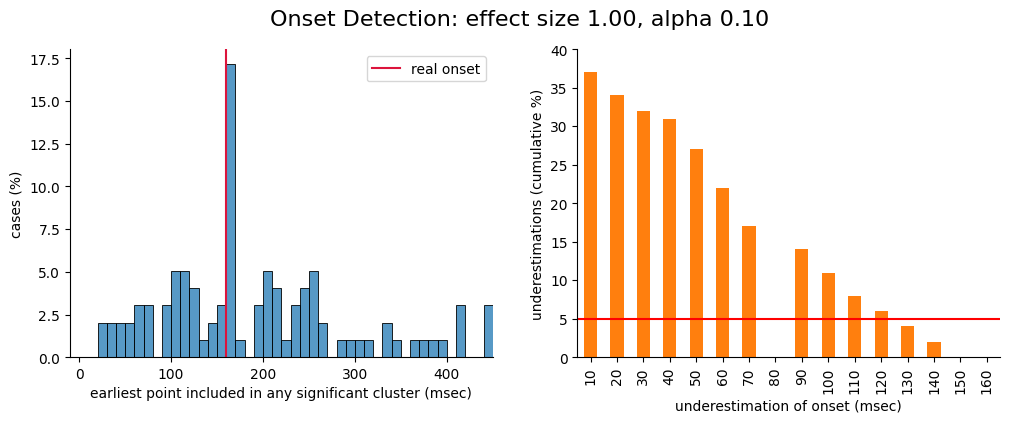

In [85]:
#
# plot results for each effect size for comparison
#
# effsizes set above

my_effsizes=[]
claims=[]
errors = []

for ii, effsize in enumerate(effsizes):
    my_effsizes.append(effsize)

    results = all_results[ii]
    total_claims = 0
    for result in results:
        if result != None:
            #print(result[0])
            for claim in result[0]:
                if claim > 0:
                    total_claims += 1
                    claims.append(int(claim) + 1)  # index 0 is first 10ms, so +1
    #print(claims)
    print("total claims = ", total_claims)
    if (total_claims > 1):
        plot_results(claims, effsizes[ii], ii)   # plot results

        # record error rates
        early = 100 * sum([r < 16 for r in claims if r]) / total_claims
        hits =  100 * sum([r == 16 for r in claims if r]) / total_claims
        late =  100 * sum([r > 16 for r in claims if r]) / total_claims
        errors.append((early, late))

### plot errors versus effect size

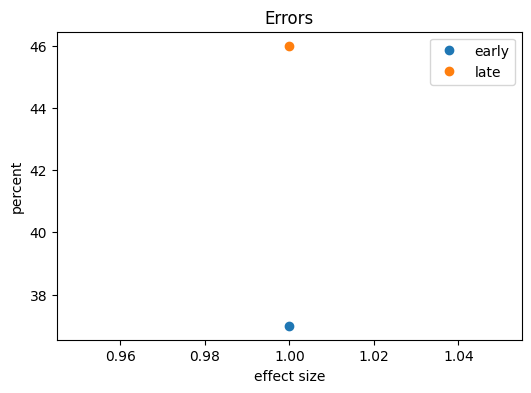

In [79]:

if errors and len(my_effsizes) > 0:
    fig=plt.figure()
    fig.set_size_inches(6, 4)
    plt.plot(my_effsizes, errors, 'o', label=["early", "late"]);
    plt.legend(loc="best");
    plt.xlabel("effect size");
    plt.ylabel("percent")
    plt.title("Errors")

